In [2]:
import pandas as pd
import os
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
import contextily as ctx
import matplotlib as mpl
from fiona.io import ZipMemoryFile
import io
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
valid_files = [
    os.path.join("../data/address", file)
    for file in os.listdir("../data/address")
    if file.split(".")[-1] == "xz"
]

total_dots_df = []

for county_file in tqdm(sorted(valid_files)):
    county_shape_df = pd.read_csv(county_file)
    county_shape_df.crs = "epsg:4326"
    total_dots_df.append(county_shape_df)

total_dots_df = pd.concat(total_dots_df)
print(total_dots_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3221/3221 [01:57<00:00, 27.34it/s]


                                          address          GEOID20  longitude  \
0      521 mossy oak ridge, prattville, al, 36066   10010205033012 -86.429760   
1    209 high pointe ridge, prattville, al, 36066   10010205033012 -86.430169   
2    208 high pointe ridge, prattville, al, 36066   10010205033012 -86.430166   
3       101 lake haven way, prattville, al, 36066   10010205033012 -86.433429   
4       103 lake haven way, prattville, al, 36066   10010205033012 -86.433428   
..                                            ...              ...        ...   
592                                           NaN  721537504001005        NaN   
593                                           NaN  721537504004036        NaN   
594                                           NaN  721537501022020        NaN   
595                                           NaN  721537505012011        NaN   
596                                           NaN  721537504003006        NaN   

      latitude  
0    32.46

# Merge the geometries, so that each county has at least one value?

In [44]:
tdf

,geometry,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,address_count,at_least_one
3955051,"POLYGON ((-90.82762 32.37308, -90.82761 32.373...",28,149,950901,2029,281499509012029,Block 2029,G5040,S,48098,0,+32.3727584,-090.8267060,0,False
7583790,"POLYGON ((-82.84076 36.65833, -82.84071 36.658...",51,169,030200,2052,511690302002052,Block 2052,G5040,S,460952,0,+36.6597146,-082.8368425,1,False
5957002,"POLYGON ((-77.13827 39.91950, -77.13720 39.919...",42,001,030200,2132,420010302002132,Block 2132,G5040,S,71101,0,+39.9181164,-077.1362359,0,False
5807495,"POLYGON ((-95.93846 36.36583, -95.93823 36.365...",40,143,005500,1048,401430055001048,Block 1048,G5040,S,48322,0,+36.3644632,-095.9375184,0,False
1845242,"POLYGON ((-83.55395 32.75882, -83.55384 32.758...",13,289,060200,1000,132890602001000,Block 1000,G5040,S,124323,0,+32.7394076,-083.5428698,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702178,"POLYGON ((-84.12355 33.71491, -84.12287 33.715...",13,089,023317,3003,130890233173003,Block 3003,G5040,S,320533,0,+33.7160055,-084.1185033,240,True
1039608,"POLYGON ((-104.85336 39.73291, -104.85300 39.7...",08,005,007400,2000,080050074002000,Block 2000,G5040,S,165586,0,+39.7312910,-104.8496032,22,True
7579301,"POLYGON ((-79.62192 37.87027, -79.62168 37.870...",51,163,930200,3107,511639302003107,Block 3107,G5040,S,1561858,0,+37.8741494,-079.6082815,0,False
6026353,"POLYGON ((-79.97079 40.88551, -79.97077 40.885...",42,019,902900,1028,420199029001028,Block 1028,G5040,S,55731,0,+40.8859467,-079.9677776,0,False


In [ ]:
from shapely.ops import cascaded_union
# polygons = [poly1[0], poly1[1], poly2[0], poly2[1]]
# boundary = gpd.GeoSeries(cascaded_union(polygons))

gdfs = []
for state in tdf['STATEFP20'].unique():
    pdf = tdf[tdf['STATEFP20'] == state]
    for county in pdf['COUNTYFP20'].unique():
        pdf = pdf[pdf['COUNTYFP20'] == county]
        geom = gpd.GeoSeries(cascaded_union(pdf['geometry']))

In [40]:
import matplotlib.colors as clrs
cmap = clrs.ListedColormap(['red', 'green'])

In [42]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

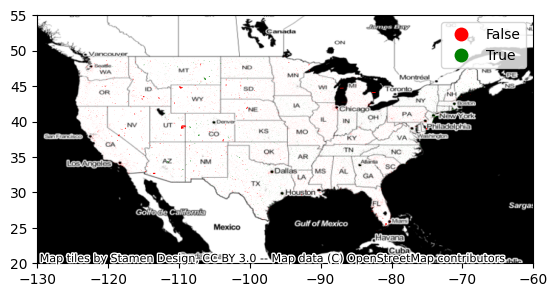

In [43]:
tdf.to_crs("EPSG:4326")
ax = tdf.plot(alpha=1, column='at_least_one', cmap=cmap, legend=True)
ctx.add_basemap(ax, crs=tdf.crs.to_string(), source=ctx.providers.Stamen.Toner)
ax.set_xlim([-130, -60])
ax.set_ylim([20, 55])
plt.savefig('../docs/us.pdf')